# Exercises week 1

In the first cells we define the needed python functions returning the gradient and the actual function f(x,y) itself.

Next, we take the previously defined functions from the notebook suggested (gd, rms_prop, adam..)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
def func(X, b = 20, q = 0.1, w = 10):
    return b*(1-np.exp(-0.5*w*(X[0]**2+X[1]**2))) + 0.5*q*(-X[0]**3 + X[1])**2

def gradx(X, b = 20, q = 0.1, w = 10):
    return b*np.exp(-0.5*w*(X[0]**2+X[1]**2)) *w*X[0] - 3*q*X[0]**2*(-X[0]**3 + X[1])

def grady(X, b = 20, q = 0.1, w = 10):
    return b*np.exp(-0.5*w*(X[0]**2 + X[1]**2))*w*X[1] + q*(-X[0]**3 + X[1])

def grad(X):
    return [gradx(X), grady(X)]

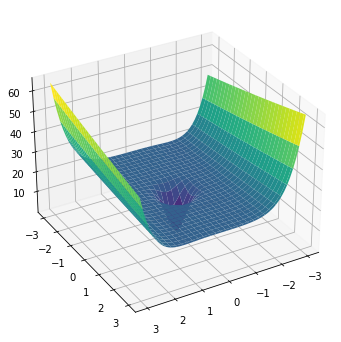

In [31]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,6))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'viridis')
ax.view_init(30,60)
#plt.show()


In [5]:
%matplotlib inline
x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)


X = np.meshgrid(x,y)

In [6]:
# Vanilla GD
def gd(grad, init, n_epochs=1000, eta=10**-4, noise_strength=0, timing=False):
    start = time.time()
    #This is a simple optimizer
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,3])
    param_traj[0,]=[init[0], init[1], 0]
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=[params[0], params[1], time.time()-start]
    if timing == False:
        return param_traj[:,:2]
    return param_traj

# Momentum GD
def gd_with_mom(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# NAG
def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

#RMS_PROP
def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
#ADAM                       
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    grad_sq=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

We may assume that the iteration time is constant for each step in the process, and simply divide the time needed to finish the function path by the number of epochs to get a single epoch time. 

This approximation is supposed to be always valid, and we checked explicitly it in the GD case.

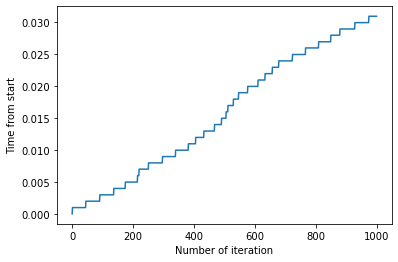

In [7]:
Xf = gd(grad, [-3, 3], timing = True) #returning x,y,t for each iteration
#print(Xf)
plt.plot(Xf[:,2])
plt.xlabel("Number of iteration")
plt.ylabel("Time from start")
plt.show()

Here we define a function returning the results for various functions.  Basically a wrapper for the previous minimization approaches.

In [8]:
def minResults(x,y,eta,epochs,minfunc, func, grad):
    Results = pd.DataFrame()
    count = 0
    start = time.time()
    for i in tqdm(x, leave = False):
        count += 1
        #print(count)
        for j in tqdm(y, leave = False): 
            Results[str(i) + " " + str(j)] = func(minfunc(grad, np.array([i,j]), eta = eta, n_epochs = epochs).T)
    end = time.time()
    return Results.mean(axis = 1), (end-start)/epochs

In [9]:
eta = [0.01, 0.001, 0.0001] #we try different learning rates

In [10]:
Results_gd = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_gd['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, gd, func, grad)
    Results_gd['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225
    

Minimize with eta =  0.01


Minimize with eta =  0.001


Minimize with eta =  0.0001


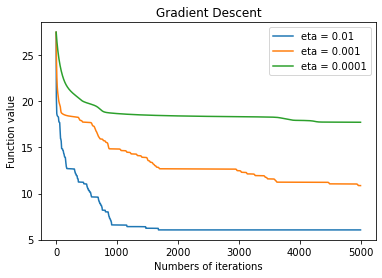

In [11]:
Results_gd.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("Gradient Descent")
plt.show()
#Results_gd

The best $\eta$ selected for this case is $\eta$ = 0.001, as it converges to a smaller value, closer to the actual minimum

In [12]:
Results_gd_mom = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_gd_mom['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, gd_with_mom, func, grad)
    Results_gd_mom['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225

Minimize with eta =  0.01


Minimize with eta =  0.001


Minimize with eta =  0.0001


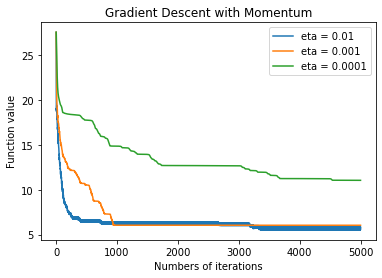

In [13]:
Results_gd_mom.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("Gradient Descent with Momentum")
plt.show()
# Results_gd_mom

In [14]:
Results_NAG = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_NAG['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, NAG, func, grad)
    Results_NAG['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225

Minimize with eta =  0.01


Minimize with eta =  0.001


Minimize with eta =  0.0001


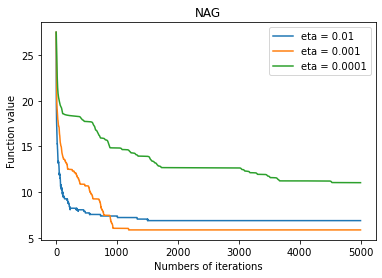

In [15]:
Results_NAG.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("NAG")

plt.show()
# Results_NAG

In [16]:
Results_rms = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_rms['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, rms_prop, func, grad)
    Results_rms['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225

Minimize with eta =  0.01


Minimize with eta =  0.001


Minimize with eta =  0.0001


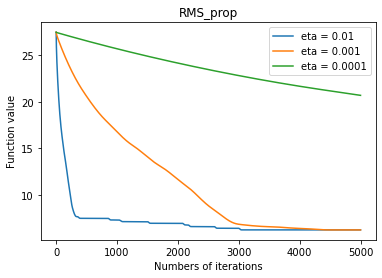

In [17]:
%matplotlib inline
Results_rms.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("RMS_prop")
plt.show()
# Results_rms

In [18]:
Results_adams = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_adams['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 5000, adams, func, grad)
    Results_adams['eta = ' + str(e) + '_time'] = np.arange(5001)*time_per_iteration/225

Minimize with eta =  0.01


Minimize with eta =  0.001


Minimize with eta =  0.0001


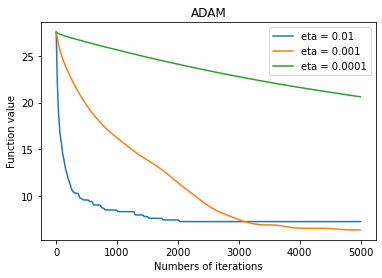

In [19]:
%matplotlib inline
Results_adams.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.title("ADAM")
plt.show()
# Results_adams

The best $\eta$ for every algotithm are choosen as the ones reaching a fast and stable convergence: 

GD: 0.01

GD_mom: 0.001

NAG: 0.001

RMS_PROP: 0.01

ADAM: 0.001

Now we plot the best results for every algorithm with the actual CPU time used.

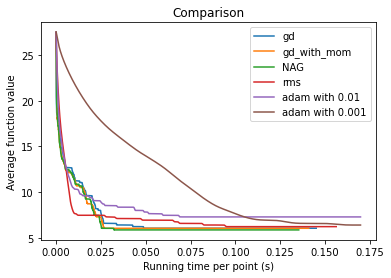

In [20]:
%matplotlib inline
plt.plot(Results_gd["eta = 0.01_time"], Results_gd["eta = 0.01"], label = "gd")
plt.plot(Results_gd_mom["eta = 0.001_time"], Results_gd_mom["eta = 0.001"], label = "gd_with_mom")
plt.plot(Results_NAG["eta = 0.001_time"], Results_NAG["eta = 0.001"], label = "NAG")
plt.plot(Results_rms["eta = 0.01_time"], Results_rms["eta = 0.01"], label = "rms")
plt.plot(Results_adams["eta = 0.01_time"], Results_adams["eta = 0.01"], label = "adam with 0.01")
plt.plot(Results_adams["eta = 0.01_time"], Results_adams["eta = 0.001"], label = "adam with 0.001")
plt.ylabel("Average function value")
plt.xlabel("Running time per point (s)")

plt.title("Comparison")
plt.legend()
plt.show()

The different minimization algorithms show a similar behaviour when considered over multiple initial points. 

Moreover, the rms one reaches more often a local minimum, and has a medium value typically higher than the other ones. 


On the other hand, the adam algorithm seems not to converge in only 2000 iterations.

<IPython.core.display.Javascript object>


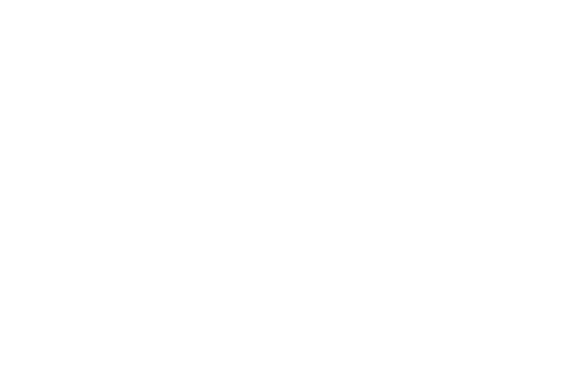

[[ 1.30000000e+00  1.00000000e+00]
 [ 1.29000000e+00  1.01000000e+00]
 [ 1.27656032e+00  1.02344756e+00]
 ...
 [-5.48877019e-18  6.36757278e-19]
 [ 6.13293122e-18  7.40986005e-18]
 [ 1.33395968e-17  4.87728455e-18]]
[ 1.30000000e+00  1.29000000e+00  1.27656032e+00 ... -5.48877019e-18
  6.13293122e-18  1.33395968e-17]


In [21]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure()
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax.view_init(30,60)
#plt.show()

oneGD = adams(grad, [1.3,1], n_epochs=1000, eta=0.01, noise_strength=0,)

ax.scatter(oneGD[:,0], oneGD[:,1], func(oneGD.T), marker = '.', color = 'green', linewidth = 1, label = "adam")
oneGD_2 = adams(grad, [0,3], n_epochs=1000, eta=0.01, noise_strength=0,)

ax.scatter(oneGD_2[:,0], oneGD_2[:,1], func(oneGD_2.T), marker = '.', color = 'red', linewidth =  1, label = "rms_prop")
oneGD_3 = rms_prop(grad, [3,0], n_epochs=10000, eta=0.01, noise_strength=0,)

ax.scatter(oneGD_3[:,0], oneGD_3[:,1], func(oneGD_3.T), marker = '.', color = 'black', linewidth =  1, label = "adam")

oneGD_4 = rms_prop(grad, [-2.5,2], n_epochs=3000, eta=0.01, noise_strength=0,)
ax.scatter(oneGD_4[:,0], oneGD_4[:,1], func(oneGD_4.T), marker = '.', color = 'black', linewidth =  1, label = "adam")

oneGD_4 = rms_prop(grad, [-2.5,2], n_epochs=3000, eta=0.01, noise_strength=0,)
ax.scatter(oneGD_4[:,0], oneGD_4[:,1], func(oneGD_4.T), marker = '.', color = 'black', linewidth =  1, label = "adam")

oneGD_5 = rms_prop(grad, [2,0], n_epochs=3000, eta=0.01, noise_strength=0,)
ax.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'black', linewidth =  1, label = "adam")

oneGD_5 = gd(grad, [3,3], n_epochs=50000, eta=0.01, noise_strength=0,)
ax.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'black', linewidth =  1, label = "adam")

# Comparison GD, Adam, RMS_prop: 

We can notice that the GD algorithm seems faster on the first steps as it follows the steep descent. 
On the other hand, the Adam and RMS prop algorithms typically have the same path but ADAM somehow stops before - maybe due to the change in the friction coefficient, while RMS prop manages to route back towards the global minimum within 50k epochs.

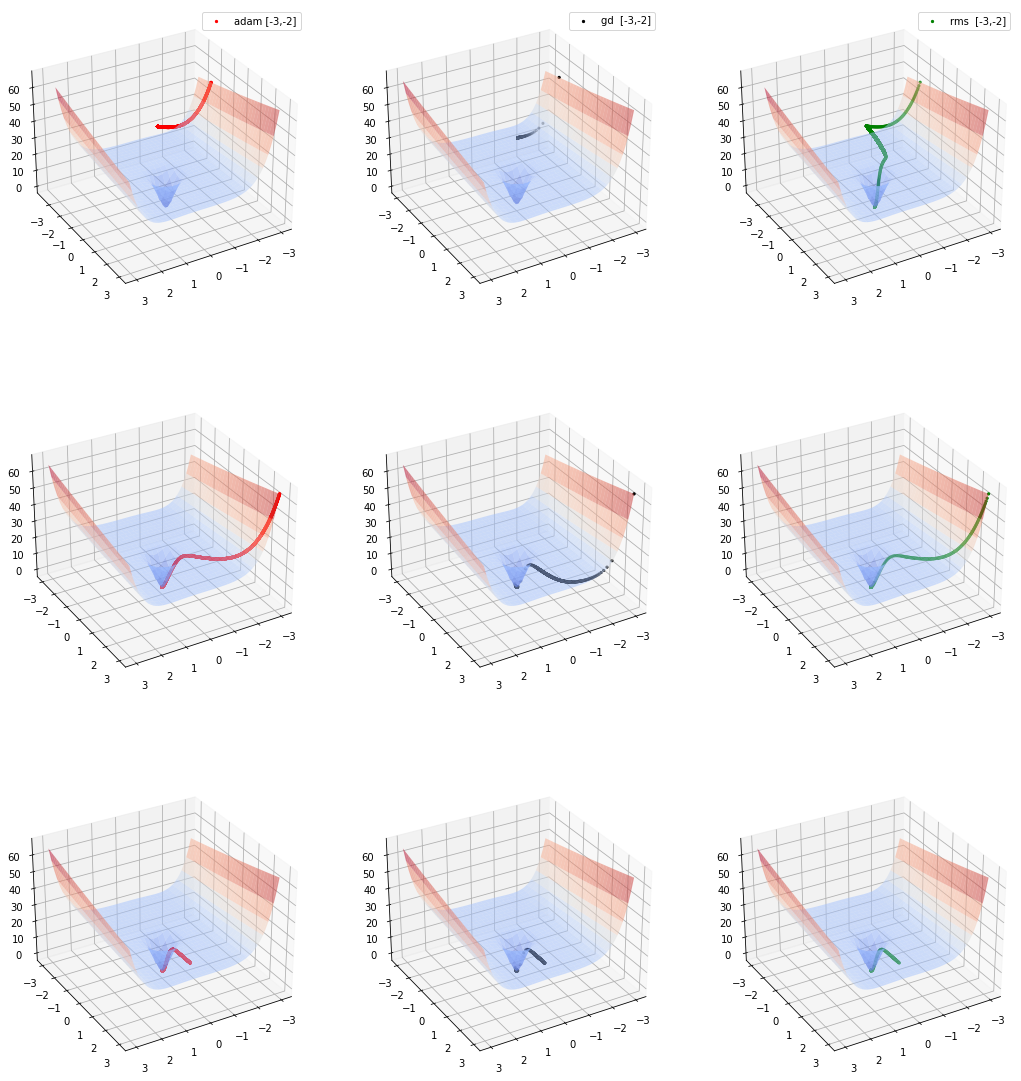

In [22]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig  = plt.figure(figsize=(18,20))

ax = fig.add_subplot(3, 3, 1, projection='3d')
ax2= fig.add_subplot(3,3,2, projection = '3d')
ax3= fig.add_subplot(3,3,3, projection = '3d')

ax4 = fig.add_subplot(3, 3, 4, projection='3d')
ax5= fig.add_subplot(3,3,5, projection = '3d')
ax6= fig.add_subplot(3,3,6, projection = '3d')


ax7= fig.add_subplot(3, 3,7, projection='3d')
ax8= fig.add_subplot(3,3,8, projection = '3d')
ax9= fig.add_subplot(3,3,9, projection = '3d')
# ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax.view_init(30,60)
ax2.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax2.view_init(30,60)
ax3.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax3.view_init(30,60)

ax4.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax4.view_init(30,60)
ax5.view_init(30,60)
ax5.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax6.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax6.view_init(30,60)
ax7.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax7.view_init(30,60)
ax8.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax8.view_init(30,60)
ax9.plot_surface(Xplot[0], Xplot[1], func(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax9.view_init(30,60)
#plt.show()


adam_3_2 = adams(grad, [-3,-2], n_epochs=50000, eta=0.001, noise_strength=0,)
ax.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'red', linewidth =  1, label = "adam [-3,-2]")
adam_3_2 = gd(grad, [-3,-2], n_epochs=50000, eta=0.01, noise_strength=0,)
ax2.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'black', linewidth =  1, label = "gd  [-3,-2]")
adam_3_2 = rms_prop(grad, [-3,-2], n_epochs=50000, eta=0.01, noise_strength=0,)
ax3.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'green', linewidth =  1, label = "rms  [-3,-2]")


adam_3_3 = adams(grad, [-3,3], n_epochs=50000, eta=0.001, noise_strength=0,)
ax4.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'red', linewidth =  1, label = "adam [-3,3]")
adam_3_3 = gd(grad, [-3,3], n_epochs=50000, eta=0.01, noise_strength=0,)
ax5.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'black', linewidth =  1, label = "gd [-3,3]")
adam_3_3 = rms_prop(grad, [-3,3], n_epochs=50000, eta=0.01, noise_strength=0,)
ax6.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'green', linewidth =  1, label = "rms [-3,3]")

oneGD_5 = adams(grad, [0,2], n_epochs=50000, eta=0.001, noise_strength=0,)
ax7.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'red', linewidth =  1, label = "adam  [0,2]")
oneGD_5 = gd(grad, [0,2], n_epochs=50000, eta=0.01, noise_strength=0,)
ax8.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'black', linewidth =  1, label = "gd  [0,2]")
oneGD_5 = rms_prop(grad, [0,2], n_epochs=50000, eta=0.01, noise_strength=0,)
ax9.scatter(oneGD_5[:,0], oneGD_5[:,1], func(oneGD_5.T), marker = '.', color = 'green', linewidth =  1, label = "rms  [0,2]")

# oneGD_3 = rms_prop(grad, [3,3], n_epochs=50000, eta=0.01, noise_strength=0,)
# ax.scatter(oneGD_3[:,0], oneGD_3[:,1], func(oneGD_3.T), marker = '.', color = 'green', linewidth =  1, label = "rms_prop")


ax.legend()
ax2.legend()
ax3.legend()

plt.show()

# Function 2

In [23]:
def func_2(X, q = 6):
    return 1 + 0.5*q* (X[0]**2+X[1]**2) - np.cos(2*np.pi*(X[0]*X[1]-X[1]**2))

def gradx_2(X,q = 6):
    return q*X[0] + 2*np.pi*X[1]*np.sin(2*np.pi*(X[0]*X[1]-X[1]**2))

def grady_2(X, q = 0.1):
    return q*X[1]+ 2*np.pi*(X[0]-2*X[1])*np.sin(2*np.pi*(X[0]*X[1]-X[1]**2))

def grad_2(X):
    return [gradx_2(X), grady_2(X)]



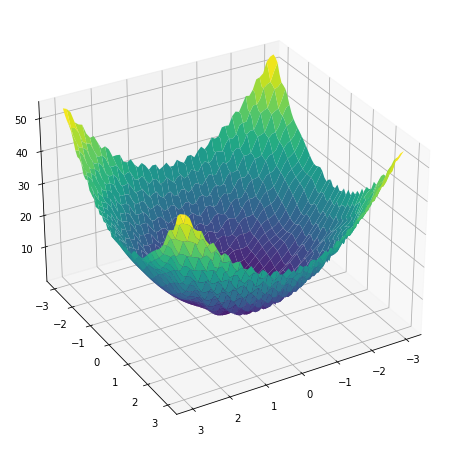

In [29]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func_2(Xplot), cmap = 'viridis')
ax.view_init(30,60)
plt.show()

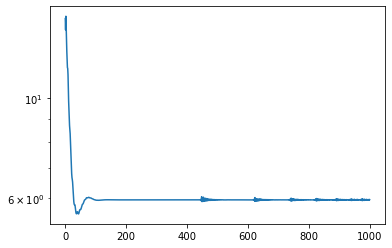

Minimize with eta =  0.01


Minimize with eta =  0.001


Minimize with eta =  0.0001


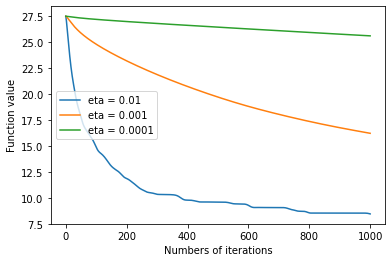

,eta = 0.01,eta = 0.01_time,eta = 0.001,eta = 0.001_time,eta = 0.0001,eta = 0.0001_time
0,27.502115,0.000000,27.502115,0.000000,27.502115,0.000000
1,27.313857,0.000041,27.483162,0.000037,27.500219,0.000039
2,27.064586,0.000083,27.457679,0.000075,27.497665,0.000077
3,26.779890,0.000124,27.427993,0.000112,27.494684,0.000116
4,26.473818,0.000165,27.395369,0.000149,27.491400,0.000155
...,...,...,...,...,...,...
996,8.484661,0.041184,16.242608,0.037222,25.619088,0.038564
997,8.477198,0.041225,16.237364,0.037260,25.617467,0.038603
998,8.469231,0.041267,16.232122,0.037297,25.615846,0.038642
999,8.460867,0.041308,16.226882,0.037334,25.614226,0.038680


In [25]:
%matplotlib inline
OneAdam = adams(grad_2, np.array([1,2]), n_epochs = 1000,eta = 0.05)
plt.plot(np.arange(1001), func_2(OneAdam.T), )
plt.yscale("log")
plt.show()

x = np.linspace(-3, 3, 15)
y = np.linspace(-3, 3, 15)


X = np.meshgrid(x,y)
Results_adams_2 = pd.DataFrame()
for e in eta:
    print('Minimize with eta = ' , e)
    Results_adams_2['eta = ' + str(e)], time_per_iteration = minResults(x, y, e, 1000, adams, func, grad)
    Results_adams_2['eta = ' + str(e) + '_time'] = np.arange(1001)*time_per_iteration/225
    
Results_adams_2.loc[:, ::2].plot()
plt.xlabel("Numbers of iterations")
plt.ylabel("Function value")
plt.show()
Results_adams_2

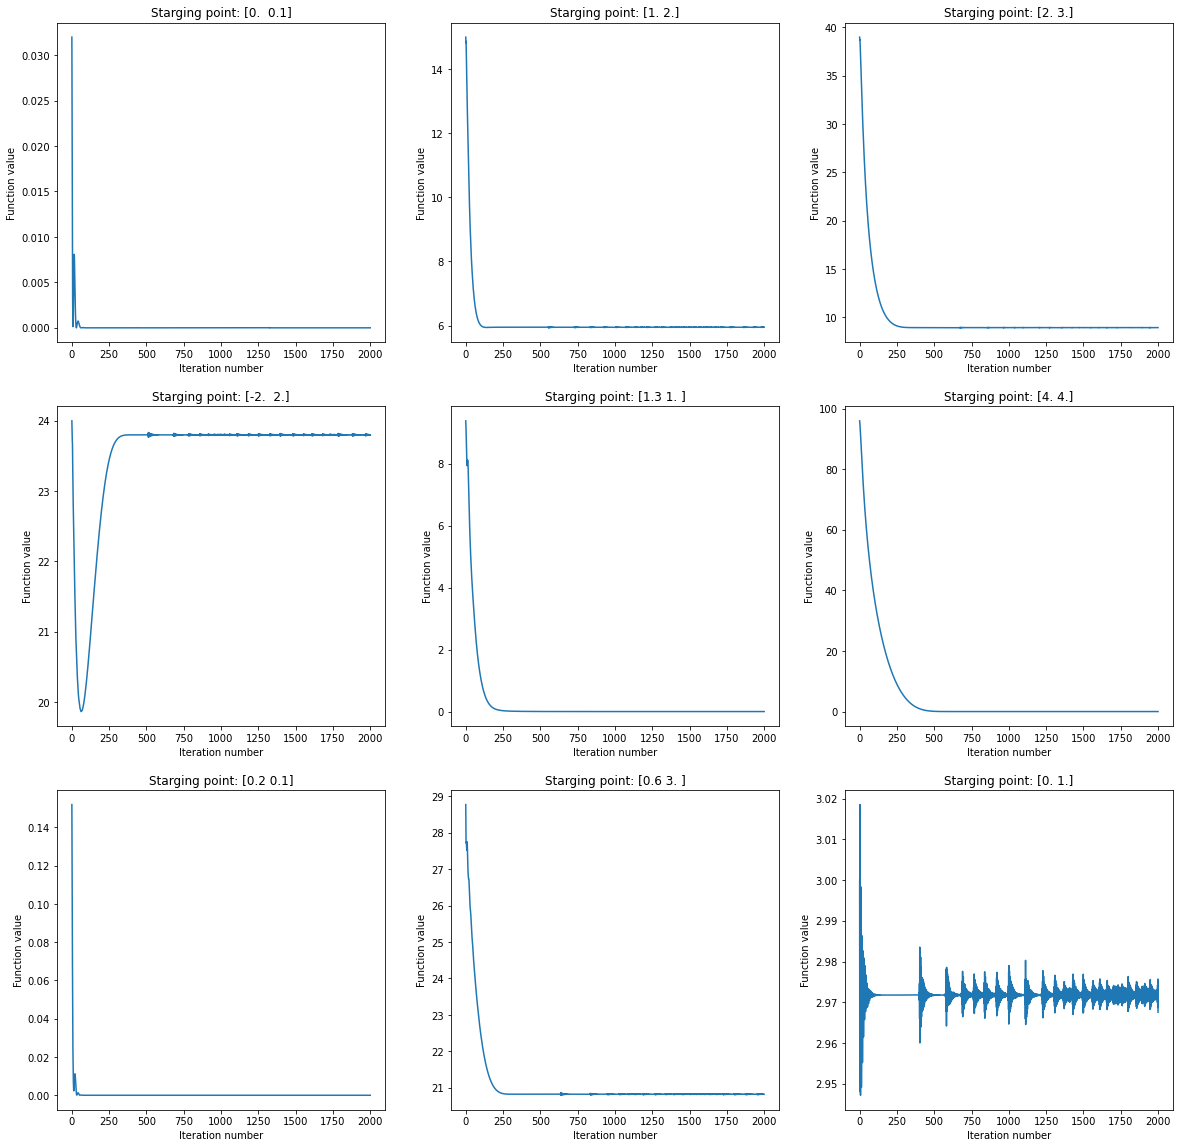

In [26]:
fig, ax = plt.subplots(3,3, figsize = (20,20))

pts_array = np.array([[0.,0.1], [1,2], [2,3], [-2,2], [1.3, 1], [4,4], [0.2, 0.1], [0.6, 3], [0,1]])
epochs = 2000
for i in range(3):
    for j in range(3):
        
        ax[i,j].plot(np.arange(epochs+1), func_2( adams(grad_2, pts_array[3*i+j], n_epochs = epochs,eta = 0.01).T) )
        ax[i,j].set_title("Starging point: "+ str( pts_array[3*i+j]))
        ax[i,j].set_xlabel("Iteration number")
        ax[i,j].set_ylabel("Function value")

plt.show()

As shown in the previous cases, the ADAM algorithm does not manage to converge in all cases. 
In the last one, in particular, it keeps bouncing between some points into the same local minima. 
Clearly this algorithm, for the second function tried, is not sufficiently stable to be relied on.

The [-2,2] case is the most unfortunate one. It starts decreasing, but then falls into a local minimum and gets stuck over there.

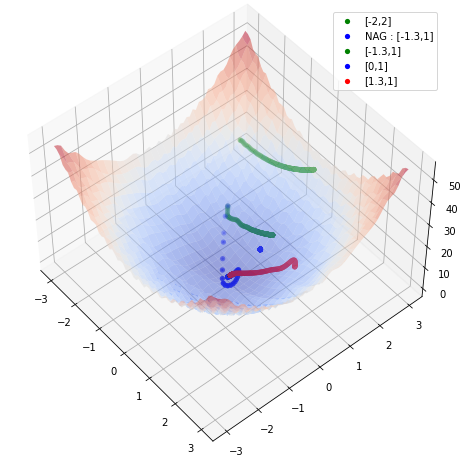

In [27]:
%matplotlib inline
xplot = np.linspace(-3, 3, 60)
yplot = np.linspace(-3, 3, 60)


Xplot = np.meshgrid(xplot,yplot)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(projection = '3d')


ax.plot_surface(Xplot[0], Xplot[1], func_2(Xplot), cmap = 'coolwarm', alpha = 0.5)
ax.view_init(50,320)
#plt.show()

oneGD = adams(grad_2, [-2,2], n_epochs=250, eta=0.01, noise_strength=0,)
ax.scatter(oneGD[:,0], oneGD[:,1], func_2(oneGD.T), marker = '.', color = 'green', linewidth = 3, label = "[-2,2]")

 #NAG here is the only algorothm managing to reach the global minimun
oneGD = NAG(grad_2, [-1.3,1], n_epochs=250, eta=0.01, noise_strength=0,)
ax.scatter(oneGD[:,0], oneGD[:,1], func_2(oneGD.T), marker = '.', color = 'blue', linewidth = 3, label = "NAG : [-1.3,1]")


oneGD = adams(grad_2, [-1.3,1], n_epochs=250, eta=0.01, noise_strength=0,)
ax.scatter(oneGD[:,0], oneGD[:,1], func_2(oneGD.T), marker = '.', color = 'green', linewidth = 3, label = "[-1.3,1]")


oneGD = adams(grad_2, [0,1], n_epochs=2000, eta=0.01, noise_strength=0,) #local minimum
ax.scatter(oneGD[:,0], oneGD[:,1], func_2(oneGD.T), marker = '.', color = 'blue', linewidth = 3, label = "[0,1]")


oneGD = adams(grad_2, [1.3,1], n_epochs=20000, eta=0.01, noise_strength=0,)
ax.scatter(oneGD[:,0], oneGD[:,1], func_2(oneGD.T), marker = '.', color = 'red', linewidth = 3, label = "[1.3,1]")

ax.legend()
plt.show()

Definitely ADAM has not a stable behaviour with this function with multiple local minima. 
Adam does not manage to reach the global minimum for various initial points